Args in experiment:
Namespace(L=3, activation='gelu', base='legendre', batch_size=32, c_out=1, checkpoints='./checkpoints/', cross_activation='tanh', d_ff=2048, d_layers=1, d_model=512, data='custom', data_path='traffic.csv', dec_in=1, des='test', devices='0,1', distil=True, do_predict=False, dropout=0.05, e_layers=2, embed='timeF', enc_in=1, factor=1, features='S', fff='C:\\Users\\David\\AppData\\Roaming\\jupyter\\runtime\\kernel-60720341-ca6e-4be3-a02f-18ea0830188e.json', freq='h', gpu=0, is_training=1, itr=3, label_len=48, learning_rate=0.0001, loss='mse', lradj='type1', mode_select='random', model='FEDformer', modes=64, moving_avg=[24], n_heads=8, num_workers=10, output_attention=False, patience=1, pred_len=96, root_path='./dataset/traffic/', seq_len=96, target='OT', task_id='test', train_epochs=2, use_amp=False, use_gpu=True, use_multi_gpu=False, version='Fourier')
Use GPU: cuda:0
this is the self.device cuda:0
fourier enhanced block used!
modes=64, index=[0, 1, 2, 3, 4, 5, 6, 7, 

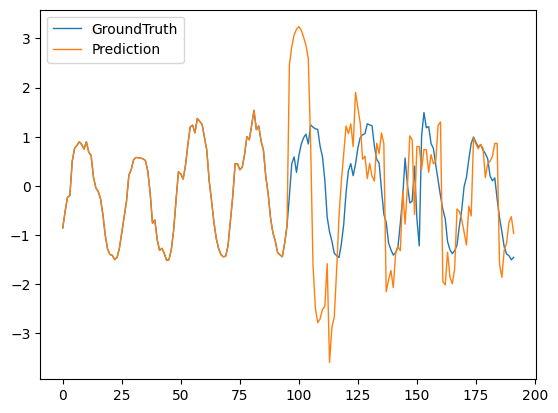

Masked Prediction


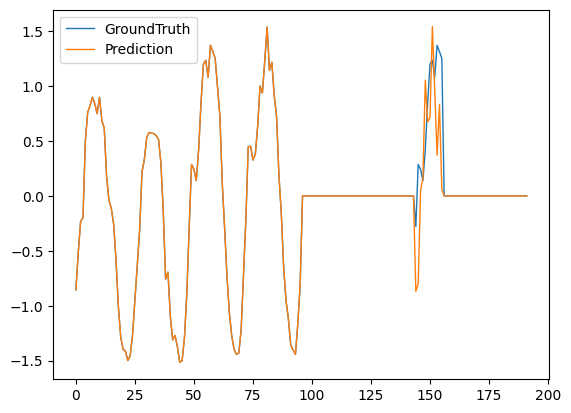

	iters: 20, epoch: 1 | loss: 1.6557109
	speed: 0.3987s/iter; left time: 293.0213s
Prediction


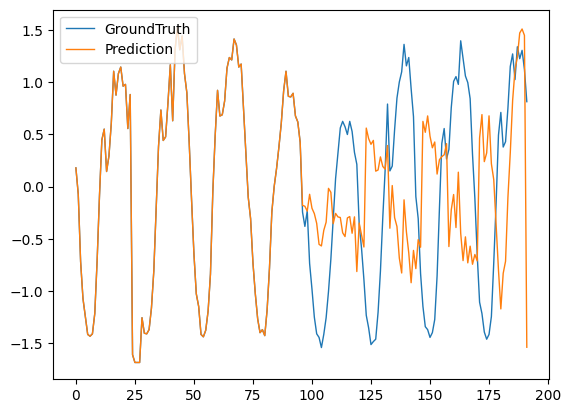

Masked Prediction


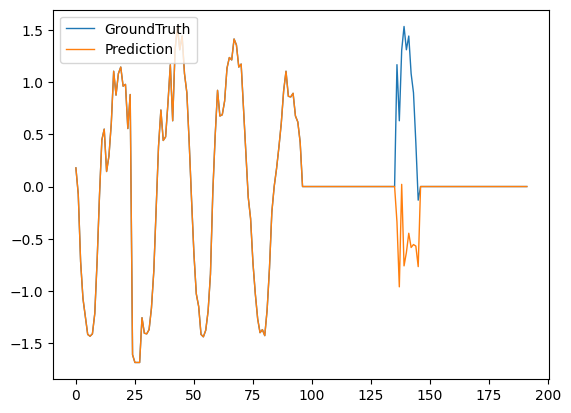

	iters: 30, epoch: 1 | loss: 3.7467003
	speed: 0.4100s/iter; left time: 297.2659s
Prediction


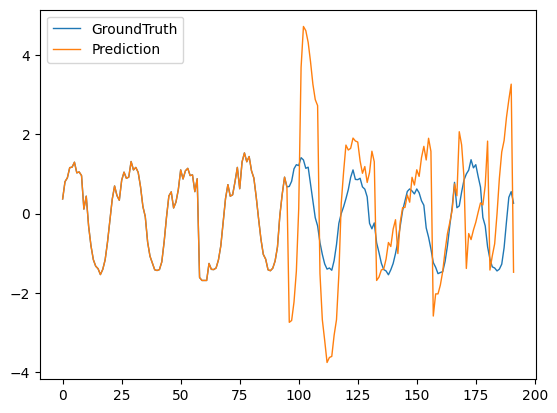

Masked Prediction


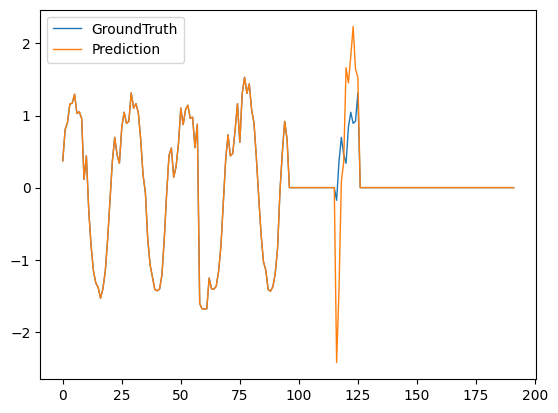

	iters: 40, epoch: 1 | loss: 4.6801219
	speed: 0.4171s/iter; left time: 298.2575s
Prediction


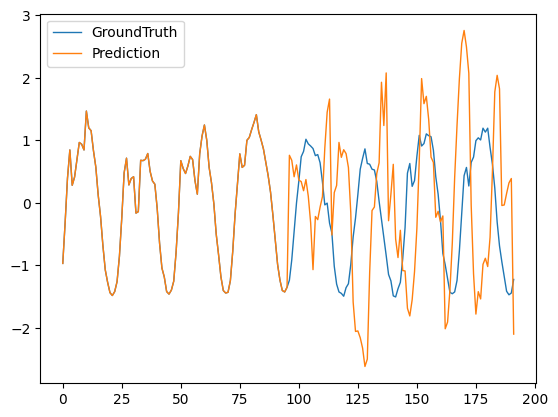

Masked Prediction


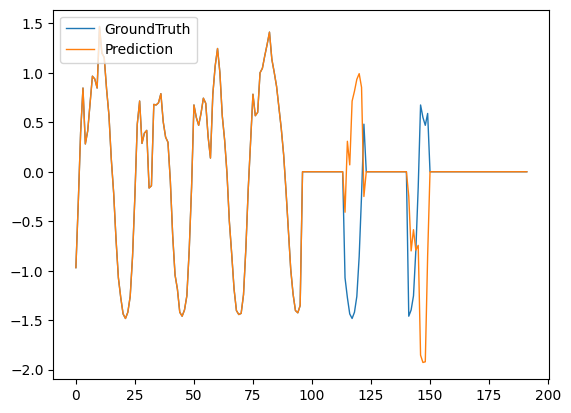

	iters: 50, epoch: 1 | loss: 6.8840179
	speed: 0.4179s/iter; left time: 294.5955s
Prediction


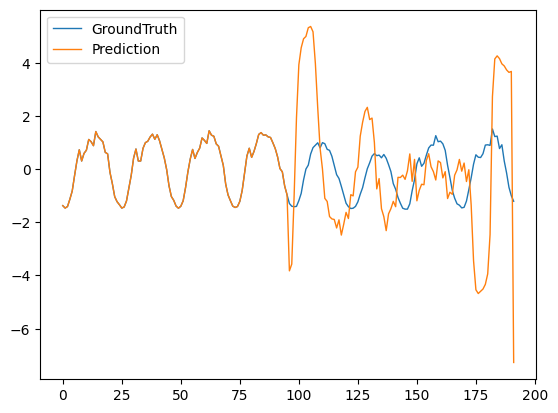

Masked Prediction


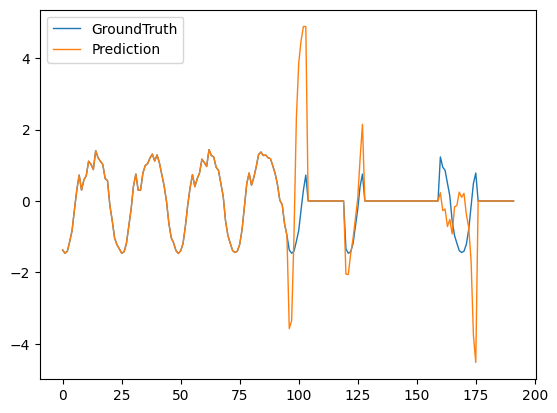

	iters: 60, epoch: 1 | loss: 7.5283351
	speed: 0.4255s/iter; left time: 295.7121s
Prediction


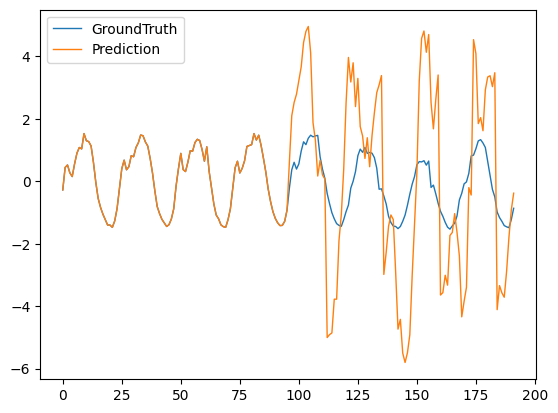

Masked Prediction


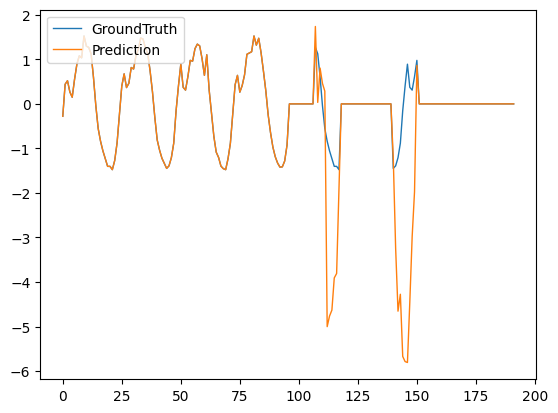

	iters: 70, epoch: 1 | loss: 13.5030899
	speed: 0.4113s/iter; left time: 281.7232s
Prediction


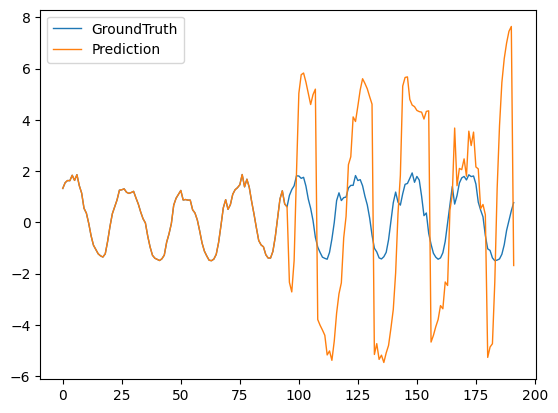

Masked Prediction


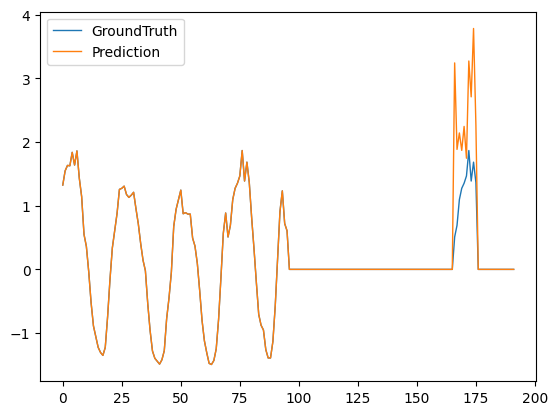

	iters: 80, epoch: 1 | loss: 7.1530471
	speed: 0.4059s/iter; left time: 274.0042s
Prediction


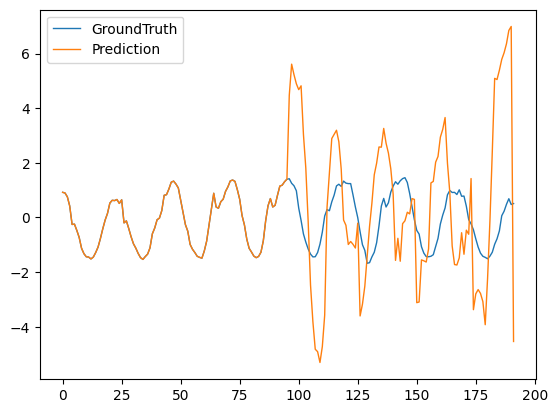

Masked Prediction


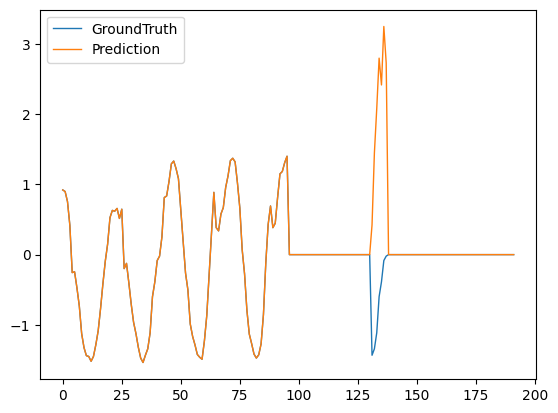

	iters: 90, epoch: 1 | loss: 8.3464031
	speed: 0.4080s/iter; left time: 271.3047s
Prediction


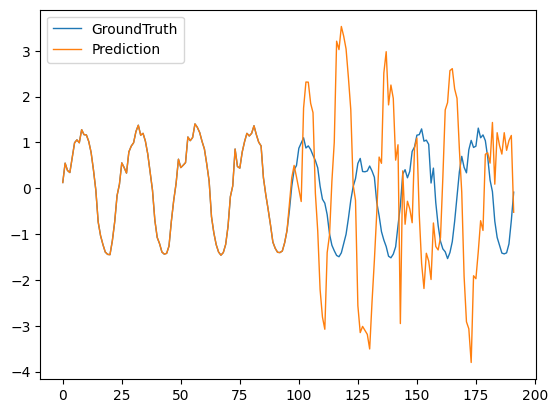

Masked Prediction


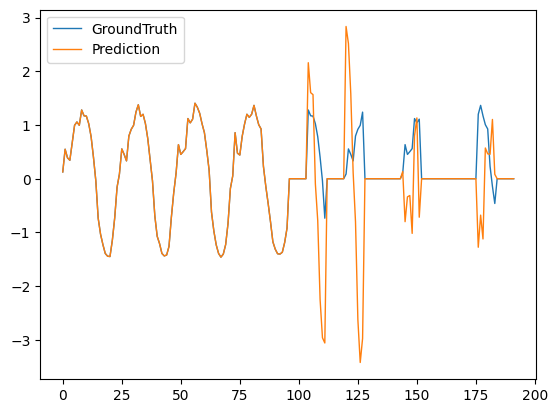

	iters: 100, epoch: 1 | loss: 4.0021887
	speed: 0.4184s/iter; left time: 274.0501s
Prediction


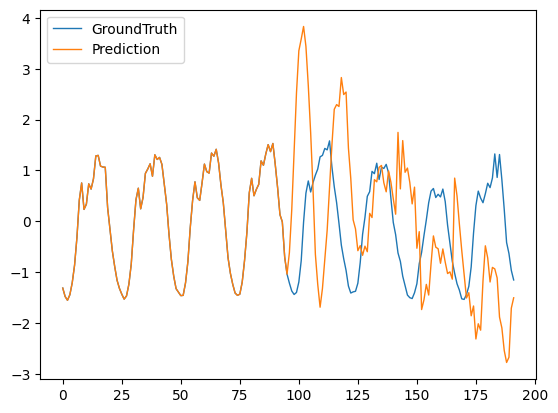

Masked Prediction


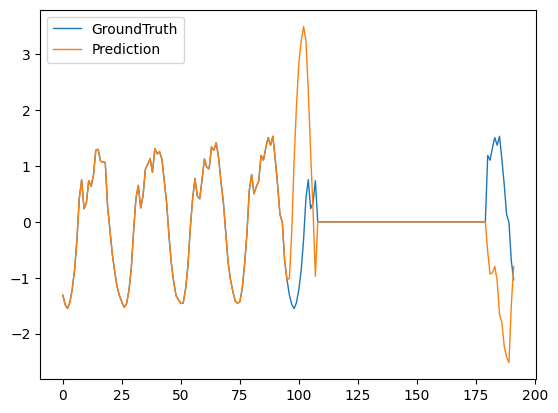

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000198D6BF01F0>
Traceback (most recent call last):
  File "C:\Users\David\miniconda3\envs\torch\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "C:\Users\David\miniconda3\envs\torch\lib\site-packages\torch\utils\data\dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\David\miniconda3\envs\torch\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "C:\Users\David\miniconda3\envs\torch\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [1]:
import argparse
import os
import sys
import torch
from exp.exp_main import Exp_Main
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


def main():
    fix_seed = 2021
    random.seed(fix_seed)
    torch.manual_seed(fix_seed)
    np.random.seed(fix_seed)

    parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

    # basic config
    parser.add_argument('--is_training', type=int, default=1, help='status')
    parser.add_argument('--task_id', type=str, default='test', help='task id')
    parser.add_argument('--model', type=str, default='FEDformer',
                        help='model name, options: [FEDformer, Autoformer, Informer, Transformer]')

    # supplementary config for FEDformer model
    parser.add_argument('--version', type=str, default='Fourier',
                        help='for FEDformer, there are two versions to choose, options: [Fourier, Wavelets]')
    parser.add_argument('--mode_select', type=str, default='random',
                        help='for FEDformer, there are two mode selection method, options: [random, low]')
    parser.add_argument('--modes', type=int, default=64, help='modes to be selected random 64')
    parser.add_argument('--L', type=int, default=3, help='ignore level')
    parser.add_argument('--base', type=str, default='legendre', help='mwt base')
    parser.add_argument('--cross_activation', type=str, default='tanh',
                        help='mwt cross atention activation function tanh or softmax')

    # data loader
    parser.add_argument('--data', type=str, default='custom', help='dataset type')
    parser.add_argument('--root_path', type=str, default='./dataset/traffic/', help='root path of the data file')
    parser.add_argument('--data_path', type=str, default='traffic.csv', help='data file')
    parser.add_argument('--features', type=str, default='S',
                        help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, '
                             'S:univariate predict univariate, MS:multivariate predict univariate')
    parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
    parser.add_argument('--freq', type=str, default='h',
                        help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, '
                             'b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
    parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

    # forecasting task
    parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
    parser.add_argument('--label_len', type=int, default=48, help='start token length')
    parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')
    # parser.add_argument('--cross_activation', type=str, default='tanh'

    # model define
    parser.add_argument('--enc_in', type=int, default=1, help='encoder input size')
    parser.add_argument('--dec_in', type=int, default=1, help='decoder input size')
    parser.add_argument('--c_out', type=int, default=1, help='output size')
    parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
    parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
    parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers') #EDITED BY DAVID S
    parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
    parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
    parser.add_argument('--moving_avg', default=[24], help='window size of moving average')
    parser.add_argument('--factor', type=int, default=1, help='attn factor')
    parser.add_argument('--distil', action='store_false',
                        help='whether to use distilling in encoder, using this argument means not using distilling',
                        default=True)
    parser.add_argument('--dropout', type=float, default=0.05, help='dropout')
    parser.add_argument('--embed', type=str, default='timeF',
                        help='time features encoding, options:[timeF, fixed, learned]')
    parser.add_argument('--activation', type=str, default='gelu', help='activation')
    parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
    parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

    # optimization
    parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
    parser.add_argument('--itr', type=int, default=3, help='experiments times')
    parser.add_argument('--train_epochs', type=int, default=2, help='train epochs')
    parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
    parser.add_argument('--patience', type=int, default=1, help='early stopping patience')
    parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
    parser.add_argument('--des', type=str, default='test', help='exp description')
    parser.add_argument('--loss', type=str, default='mse', help='loss function')
    parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
    parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

    # GPU
    parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
    parser.add_argument('--gpu', type=int, default=0, help='gpu')
    parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
    parser.add_argument('--devices', type=str, default='0,1', help='device ids of multi gpus')
    parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

    args = parser.parse_args()

    args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

    if args.use_gpu and args.use_multi_gpu:
        args.devices = args.devices.replace(' ', '')
        device_ids = args.devices.split(',')
        args.device_ids = [int(id_) for id_ in device_ids]
        args.gpu = args.device_ids[0]

    print('Args in experiment:')
    print(args)

    Exp = Exp_Main

    if args.is_training:
        for ii in range(args.itr):
            # setting record of experiments
            setting = '{}_{}_{}_modes{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
                args.task_id,
                args.model,
                args.mode_select,
                args.modes,
                args.data,
                args.features,
                args.seq_len,
                args.label_len,
                args.pred_len,
                args.d_model,
                args.n_heads,
                args.e_layers,
                args.d_layers,
                args.d_ff,
                args.factor,
                args.embed,
                args.distil,
                args.des,
                ii)

            exp = Exp(args)  # set experiments
            print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
            exp.train(setting)

            print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
            exp.test(setting)

            if args.do_predict:
                print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
                exp.predict(setting, True)

            torch.cuda.empty_cache()
    else:
        ii = 0
        setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(args.model_id,
                                                                                                      args.model,
                                                                                                      args.data,
                                                                                                      args.features,
                                                                                                      args.seq_len,
                                                                                                      args.label_len,
                                                                                                      args.pred_len,
                                                                                                      args.d_model,
                                                                                                      args.n_heads,
                                                                                                      args.e_layers,
                                                                                                      args.d_layers,
                                                                                                      args.d_ff,
                                                                                                      args.factor,
                                                                                                      args.embed,
                                                                                                      args.distil,
                                                                                                      args.des, ii)

        exp = Exp(args)  # set experiments
        print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.test(setting, test=1)
        torch.cuda.empty_cache()


if __name__ == "__main__":
    main()
